# Plot of endolichenic fungi assembly data

This Notebook plots data for the low-coverage short read assemblies generated by the Fungiflow pipeline for endolichenic fungi.

There are several PairGrid plots describing the assembly metrics by sequencing batch and fungal Class.
A Principal Components analysis (PCA) is then performed to identify relationships between this data.

In [59]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import prince

## Fig. 4.5 - Read coverage for two different pooled libraries of ELF.
All the ELF were sequenced using the Illumina MiSeq platform generating paired 150 bp reads. This figure displays the actual and estimated coverage of Illumina sequencing reads for each of the two sequencing runs. Estimated coverage reads are calculated using the aforementioned formula but with an average genome size for an Ascomycete (44.4 Mbp).[^genome_size].

The `ELF_master_results.csv` datafile is imported to pandas. To make comparisons of any differences between the two sequencing library runs, a new categorical column 'pooled_library' is added, based on which sequencing run an individual ELF isolate was a part of (1 = isolates 1-147, 2 = isolates 148+). Additionally, a column 'complete_buscos' containing the percentage of complete BUSCOs (A metric for understanding genome completedness) as an integer is prepared, as well as the actual read coverage calculated by using the formula $$ c = {n * r \over A} $$ where coverage ($c$) is calculated from $n$ total number of reads, $r$ read length (150 bp in this case), and $A$ the assembly size in bp. For several assemblies, the actual coverage value was very high, as the assembly was very small and poorly assembled given the number of reads. Therefore a threshold value of 400× was used and any datapoints with actual coverage over this were excluded.

[^genome_size]: Ramos, A. P. et al. Flow cytometry reveals that the rust fungus, *Uromyces bidentis* (Pucciniales), possesses the largest fungal genome reported—2489 M bp. *Molecular Plant Pathology* 16, 1006-1010 (2015).

In [60]:
df = pd.read_csv("../ELF_master_results.csv")
# add batch number to the dataframe
df.loc[(df['Assembly'] <= 147), 'pooled_library'] = '1'
df.loc[(df['Assembly'] > 147), 'pooled_library'] = '2'
df["complete_buscos"] = df["BUSCO - C"].str.split("(").str[1].str.split("%").str[0]
df["actual_coverage"] = (df["# total reads"]*150)/df["Total length"]
df = df[df.actual_coverage < 400] # 
df

,Assembly,estimated_coverage,# contigs (>= 0 bp),# contigs (>= 1000 bp),# contigs (>= 5000 bp),# contigs (>= 10000 bp),# contigs (>= 25000 bp),# contigs (>= 50000 bp),Total length (>= 0 bp),Total length (>= 1000 bp),...,Host_Order,Host_Family,Host_Genus,Host_Species,Photobiont,Growth_form,Macroclimate,pooled_library,complete_buscos,actual_coverage
0,1,7.94,29376.0,10468.0,131.0,0.0,0.0,0.0,29822526.0,19470784.0,...,Peltigerales,Lobariaceae,Pseudocyphellaria,crocata,Cyano,Foliose,"Mild, sub-humid",1,49.62,12.621764
1,2,1.18,9865.0,55.0,0.0,0.0,0.0,0.0,2995996.0,77858.0,...,Peltigerales,Lobariaceae,Pseudocyphellaria,crocata,Cyano,Foliose,"Mild, sub-humid",1,0.4,100.296152
2,3,0.75,7512.0,30.0,0.0,0.0,0.0,0.0,2230939.0,47631.0,...,Peltigerales,Lobariaceae,Pseudocyphellaria,crocata,Cyano,Foliose,"Mild, sub-humid",1,0.2,107.740790
3,4,82.94,3325.0,1114.0,150.0,40.0,5.0,1.0,4562683.0,3427476.0,...,Peltigerales,Lobariaceae,Pseudocyphellaria,crocata,Cyano,Foliose,"Mild, sub-humid",1,NaN,268.158867
4,5,0.51,5586.0,22.0,0.0,0.0,0.0,0.0,1626070.0,29487.0,...,Peltigerales,Lobariaceae,Pseudocyphellaria,crocata,Cyano,Foliose,"Mild, sub-humid",1,0.2,106.147437
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,376,50.88,1512.0,1259.0,1059.0,839.0,482.0,193.0,33318476.0,33206231.0,...,Lecanorales,Stereocaulaceae,Stereocaulon,ramulosum,Tripartite,Fruticose,"Mild, sub-humid",2,92.45,0.000000
376,377,5.70,66866.0,1474.0,3.0,0.0,0.0,0.0,24553797.0,1957589.0,...,Lecanorales,Stereocaulaceae,Stereocaulon,ramulosum,Tripartite,Fruticose,"Mild, sub-humid",2,1.5,25.070219
377,378,5.41,57102.0,6388.0,0.0,0.0,0.0,0.0,31750373.0,8856335.0,...,Lecanorales,Stereocaulaceae,Stereocaulon,ramulosum,Tripartite,Fruticose,"Mild, sub-humid",2,13.64,10.723522
378,379,27.98,34386.0,14340.0,661.0,33.0,0.0,0.0,42344727.0,31426038.0,...,Lecanorales,Stereocaulaceae,Stereocaulon,ramulosum,Tripartite,Fruticose,"Mild, sub-humid",2,42.99,0.000000


In [61]:
display(df[["Assembly", "actual_coverage"]].sort_values(by="actual_coverage", ascending=False))


,Assembly,actual_coverage
255,256,374.886432
165,166,304.028803
48,49,302.054389
3,4,268.158867
214,215,264.775034
...,...,...
183,184,0.000000
310,311,0.000000
184,185,0.000000
308,309,0.000000


To plot the different coverages for each sequencing set, the mean for estimated and actual coverage for each sequencing run needs to be calculated. A side-by-side line plot of each sequencing runs coverages is prepared. The differences in density between the estimated and actual coverages observed is likely due to removal of a number of reads during the kraken2 taxonomic filtering step.

13.405968992248061 21.816822916666666 29.28962918593426 38.08744021661999


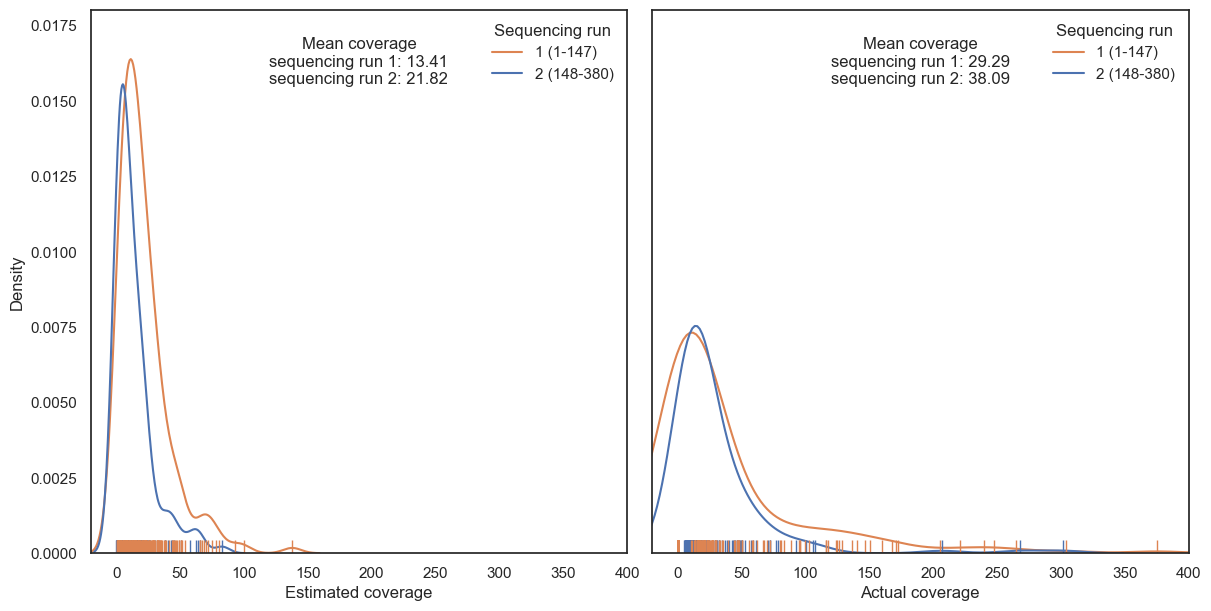

In [62]:
# calculate means
est_1_avg = df[df["pooled_library"] == "1"]["estimated_coverage"].mean()
est_2_avg = df[df["pooled_library"] == "2"]["estimated_coverage"].mean()
act_1_avg = df[df["pooled_library"] == "1"]["actual_coverage"].mean()
act_2_avg = df[df["pooled_library"] == "2"]["actual_coverage"].mean()
print(est_1_avg, est_2_avg, act_1_avg,act_2_avg)
# plot figure
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True, layout="constrained")
sns.kdeplot(data=df, x="estimated_coverage", ax=axes[0], hue="pooled_library")
sns.rugplot(data=df, x="estimated_coverage", ax=axes[0], hue="pooled_library")
sns.kdeplot(data=df, x="actual_coverage", ax=axes[1], hue="pooled_library")
sns.rugplot(data=df, x="actual_coverage", ax=axes[1], hue="pooled_library")
axes[0].legend(["1 (1-147)", "2 (148-380)"], title = 'Sequencing run', loc = 'best', frameon = False, markerscale=4)
axes[1].legend(["1 (1-147)", "2 (148-380)"], title = 'Sequencing run', loc = 'best', frameon = False, markerscale=4)
axes[0].set_xlim(-20, 400)
axes[1].set_xlim(-20, 400)
axes[0].set_ylabel("Density")
axes[0].set_xlabel("Estimated coverage")
axes[1].set_xlabel("Actual coverage")
axes[0].text(x=0.5, y=0.95, s=f"Mean coverage\nsequencing run 1: {round(est_1_avg, 2)}\nsequencing run 2: {round(est_2_avg, 2)}", ha='center', va='top', transform=axes[0].transAxes)
axes[1].text(x=0.5, y=0.95, s=f"Mean coverage\nsequencing run 1: {round(act_1_avg, 2)}\nsequencing run 2: {round(act_2_avg, 2)}", ha='center', va='top', transform=axes[1].transAxes)
plt.savefig("read_coverages.svg", format="svg", bbox_inches='tight')

## Fig. 4.6 - Comparison of assembly metrics from ELF assemblies.
To assess the spread of assembly quality, several assembly metrics can be compared to identify 'contiguous' genomes from ones that are not. Relevant metrics include:
- [N50](https://en.wikipedia.org/wiki/N50,_L50,_and_related_statistics) = a measure of assembly contiguity - the higher this value is, the more complete a genome can be considered. Technically, if all assembly contigs were sorted short to long, it is the length of the shortest contig below which 50% of the total genome length is contained.
- [L50](https://en.wikipedia.org/wiki/N50,_L50,_and_related_statistics) = the lower the better - the smallest number of contigs for which 50% of the total genome length is contained. 
- no. contigs = generally speaking, for two assemblies of equivalent size, the one with fewer assembly contigs will be more contiguous as it implies that more reads have been combined into fewer and longer contigs.
- BGC count = whilst the number of BGCs generally falls along taxonomic lines,[^bgc_taxon] the higher genome contiguity is, the more BGCs can be gleaned from the assembly using antiSMASH. Additionally, a 5000 Kbp threshold is used for antiSMASH, so the longer contigs are on average, the more contigs will pass this threshold.
- assembly length = like above, this is related to taxonomy,[^genome_size] but assemblies with longer lengths are generally more contiguous.

Below is a function to categorise the total BGC length value so we can apply a hue to markers on a scatterplot for easier interpretation.

[^bgc_taxon]: Robey, M. T., Caesar, L. K., Drott, M. T., Keller, N. P. & Kelleher, N. L. An interpreted atlas of biosynthetic gene clusters from 1,000 fungal genomes. *Proceedings of the National Academy of Sciences* 118, e2020230118, doi:doi:10.1073/pnas.2020230118 (2021).

In [63]:
# function to categorize BGC length data
def cat(x):
    if x < 0.1:
        return "<0.1"
    elif x < 0.5:
        return "0.1-0.5"
    elif x < 1:
        return "0.5-1"
    elif x < 1.5:
        return "1-1.5"
    elif x < 2:
        return "1.5-2"
    elif x < 2.5:
        return "2-2.5"
    elif x < 3:
        return "2.5-3"
    elif x >= 3:
        return ">3"
    else:
        return "<0.1"

A new dataframe is prepared from a subset of the relevant data.

In [64]:
# take subset of dataframe
df3 = df[["actual_coverage", "# contigs", "pooled_library", "N50", "L50", "Total length", "BGC_count", "total_BGC_length", "complete_buscos"]]
df3["dataset"] = "ELF"
df3["BGC total length (Mbp)"] = df3["total_BGC_length"].div(1000000).apply(lambda x: cat(x)) # apply the BGC categorising function `cat` to each datapoint
df3["Assembly length (Mbp)"] = df3["Total length"].div(1000000)
df3 = df3.rename(columns={"complete_buscos":"Complete BUSCOS (%)"})
df3 = df3.drop(columns=['total_BGC_length', "Total length"])
df3.reindex()
df3.to_csv("metrics_dataset.csv")
df3.head()

C:\Users\styleske\AppData\Local\Temp\ipykernel_12144\3491333859.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3["dataset"] = "ELF"
C:\Users\styleske\AppData\Local\Temp\ipykernel_12144\3491333859.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3["BGC total length (Mbp)"] = df3["total_BGC_length"].div(1000000).apply(lambda x: cat(x)) # apply the BGC categorising function `cat` to each datapoint
C:\Users\styleske\AppData\Local\Temp\ipykernel_12144\3491333859.py:5: SettingWithCopyWarning: 
A value

,actual_coverage,# contigs,pooled_library,N50,L50,BGC_count,Complete BUSCOS (%),dataset,BGC total length (Mbp),Assembly length (Mbp)
0,12.621764,20079.0,1,1548.0,5392.0,7.0,49.62,ELF,<0.1,26.325374
1,100.296152,608.0,1,645.0,230.0,0.0,0.4,ELF,<0.1,0.422249
2,107.740790,365.0,1,628.0,137.0,0.0,0.2,ELF,<0.1,0.251402
3,268.158867,2093.0,1,3027.0,296.0,1.0,NaN,ELF,<0.1,4.107569
4,106.147437,244.0,1,666.0,94.0,0.0,0.2,ELF,<0.1,0.169957


A PairGrid plot is prepared, comparing all the different columns from `df3` to one another. The hue for each marker is taken from the categorical BGC length column.

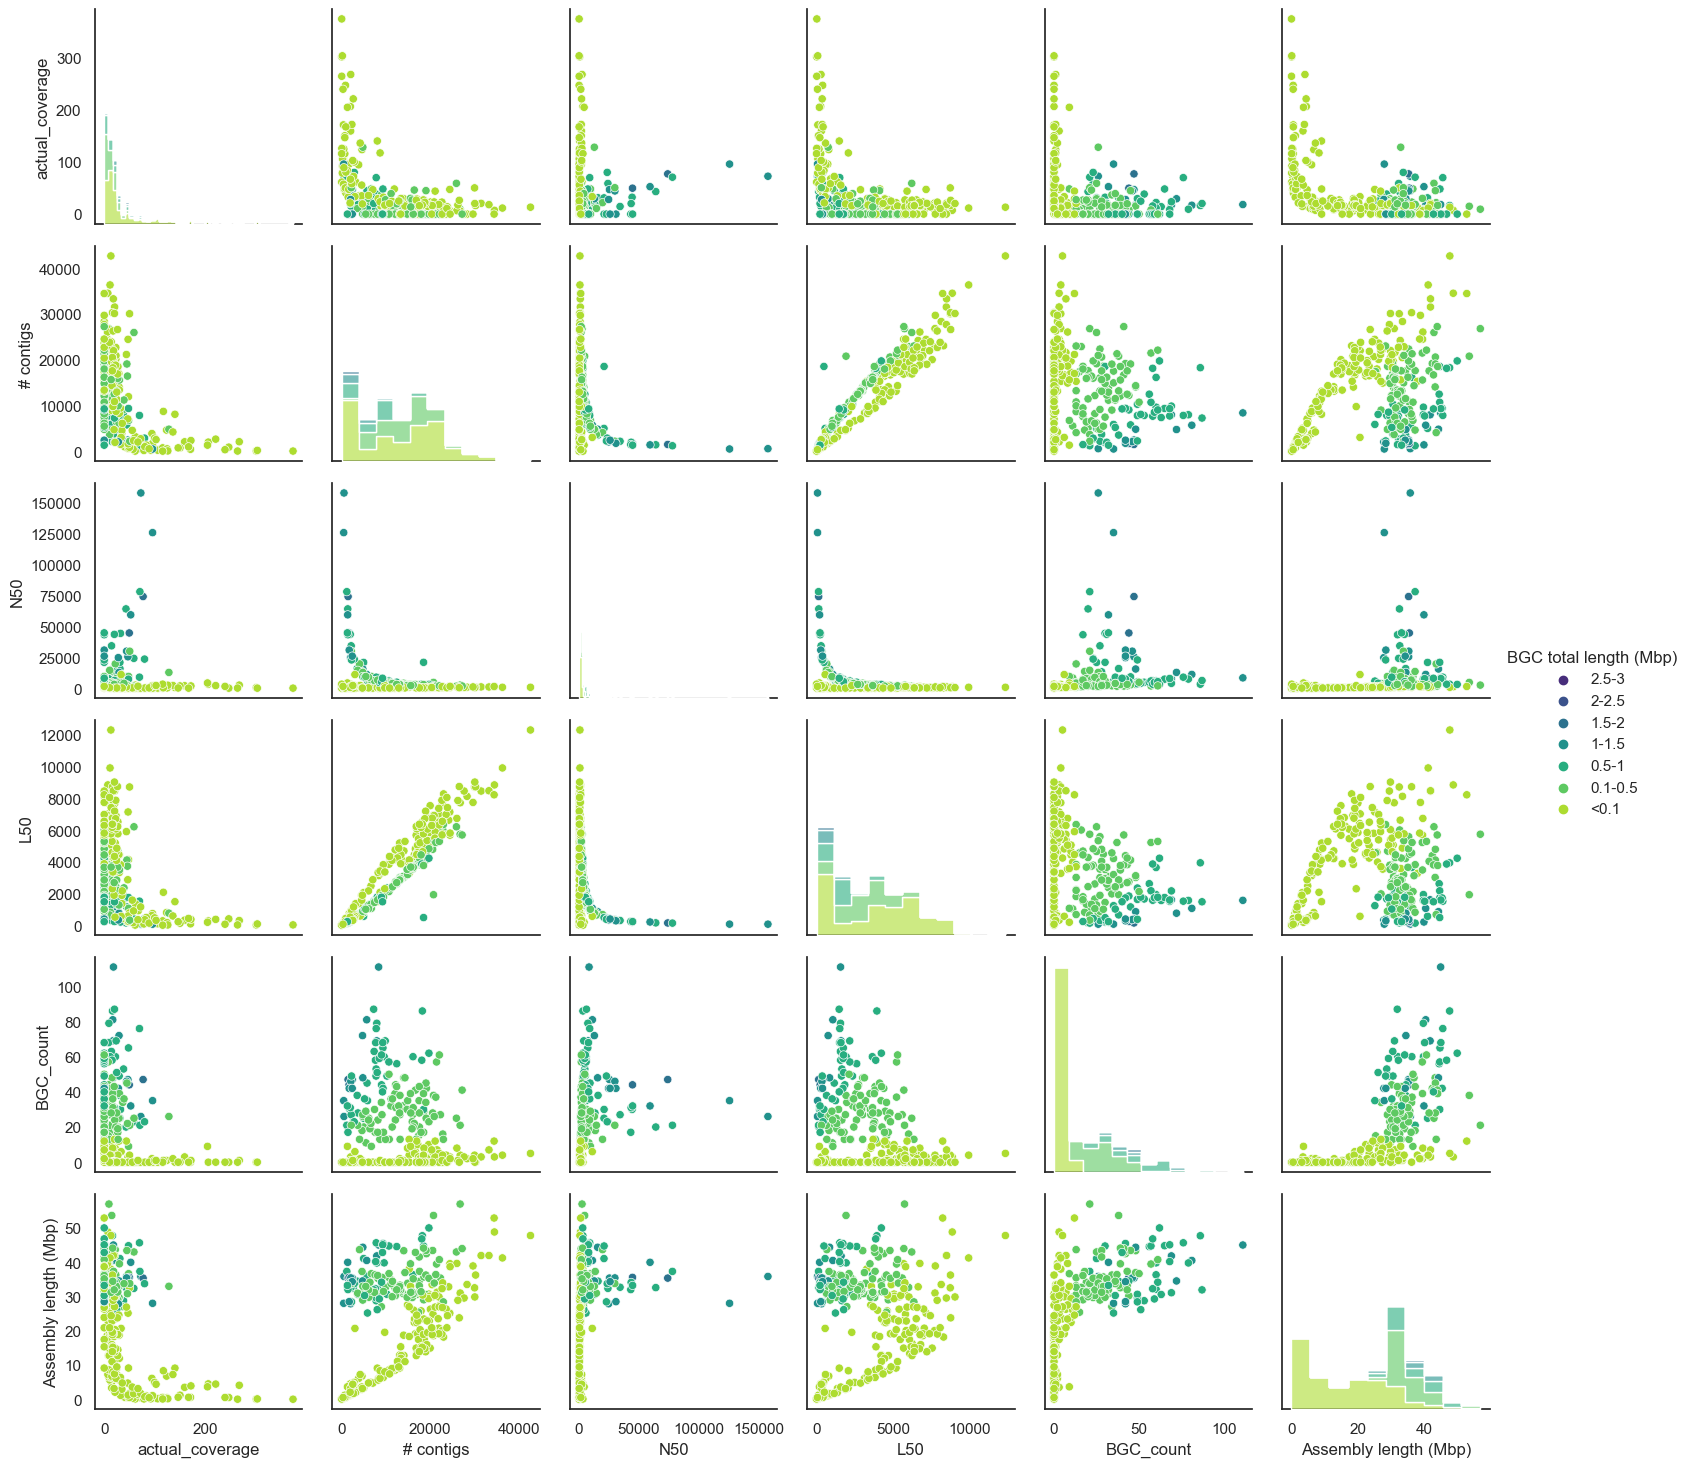

In [65]:
sns.set_palette('viridis')
sns.set(rc={'figure.figsize':(8,8)})
sns.set_style(style='white')
sns.set_context("notebook", font_scale=1)

# Use PairGrid to get different markers for 'dataset' and colours for 'BGC total length (Mbp)'
g = sns.PairGrid(data=df3, hue="BGC total length (Mbp)", hue_order=["2.5-3","2-2.5","1.5-2","1-1.5","0.5-1","0.1-0.5","<0.1"], palette="viridis")
g.map_diag(sns.histplot, color=".3", multiple="stack", element="step", alpha=0.6)
g.map_offdiag(sns.scatterplot)
g.add_legend(title=None)
plt.savefig("ELF_all_v_all_metrics.svg", format="svg")
plt.show()

Because that's such a large figure and much of the data we can infer can be summarized in a smaller figure, the same figure is prepared but for a subset of the comparisons.

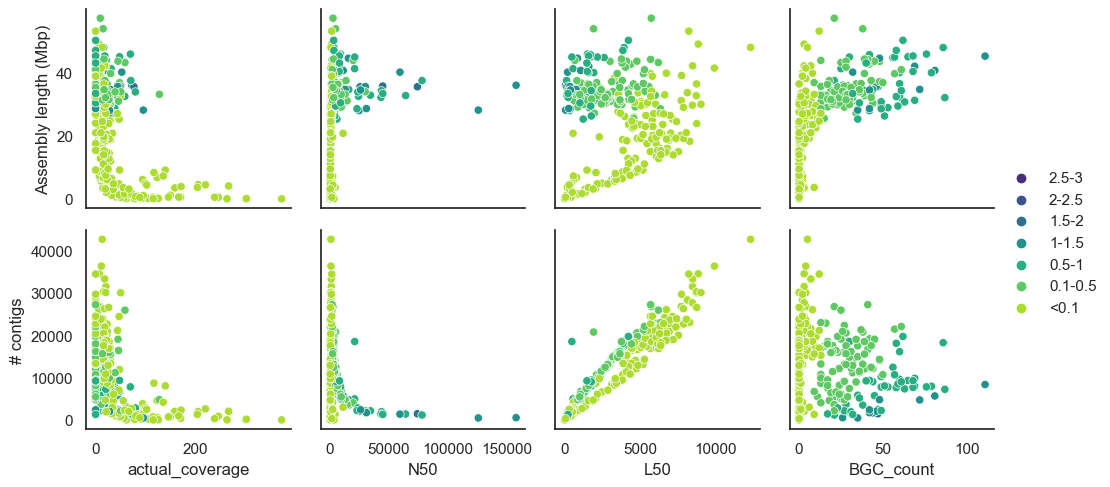

In [66]:
g = sns.PairGrid(data=df3, \
                 y_vars=["Assembly length (Mbp)", "# contigs"], \
                 x_vars=["actual_coverage", "N50", "L50", "BGC_count"],
                 hue="BGC total length (Mbp)", \
                 hue_order=["2.5-3","2-2.5","1.5-2","1-1.5","0.5-1","0.1-0.5","<0.1"], \
                 palette="viridis")
g.map_diag(sns.histplot, color=".3", multiple="stack", element="step", alpha=0.8)
g.map_offdiag(sns.scatterplot)
g.add_legend(title="", adjust_subtitles=True)
plt.savefig("ELF_assembly_length_v_metrics.svg", format="svg")
plt.show()

In the next figure, each marker shape is changed based on the sequencing run it came from. This should highlight whether there are any major differences in the assembly metrics between the two sequencing runs.

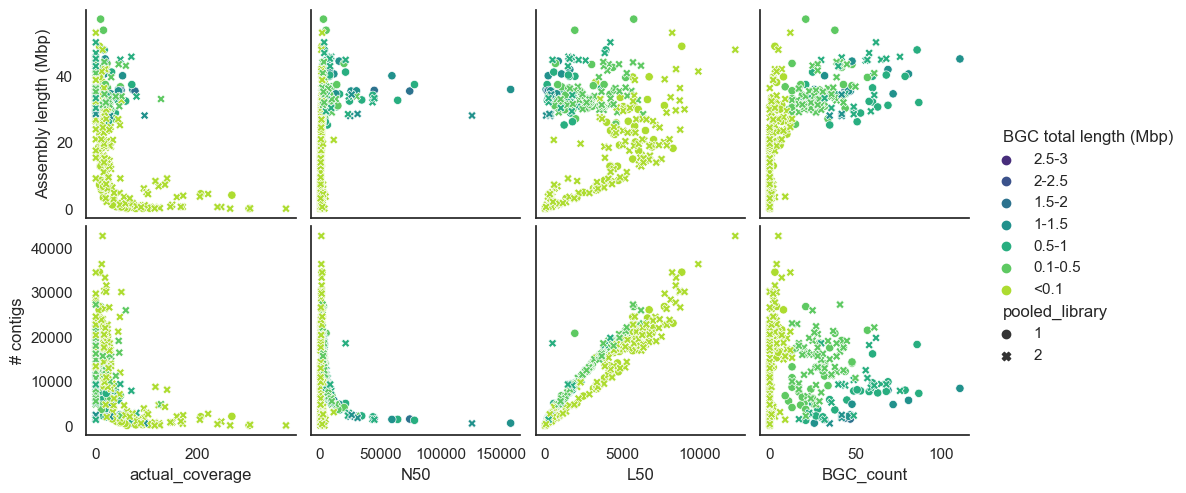

In [67]:
g = sns.PairGrid(data=df3, \
                 y_vars=["Assembly length (Mbp)", "# contigs"], \
                 x_vars=["actual_coverage", "N50", "L50", "BGC_count"],
                 hue="BGC total length (Mbp)", \
                 hue_order=["2.5-3","2-2.5","1.5-2","1-1.5","0.5-1","0.1-0.5","<0.1"], \
                 palette="viridis")
g.map_diag(sns.histplot, color=".3", multiple="stack", element="step", alpha=0.8)
g.map_offdiag(sns.scatterplot, style=df3["pooled_library"])
g.add_legend(title="", adjust_subtitles=True)
g.tight_layout()
plt.savefig("ELF_assembly_length_v_metrics_by_batch.svg", format="svg")
plt.show()

Next the same figure as above is prepared, but the markers are coloured by the Class of the ELF, rather than total BGC length. Both the previous figure and the next were combined in an SVG editor.

In [68]:
df4 = df[["actual_coverage", "# contigs", "pooled_library", "N50", "L50", "Total length", "BGC_count", "total_BGC_length", "complete_buscos", "Subject Name", "isolate_class"]]
df4["BGC total length (Mbp)"] = df4["total_BGC_length"].div(1000000).apply(lambda x: cat(x))
df4["Assembly length (Mbp)"] = df4["Total length"].div(1000000)
df4["Species"] = df4["Subject Name"].str.split(" ", expand=True)[0]
df4["Class"] = df4["isolate_class"]
df4 = df4.drop(columns=['Subject Name', 'total_BGC_length', "Total length", "isolate_class"])
df4

C:\Users\styleske\AppData\Local\Temp\ipykernel_12144\4153698447.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4["BGC total length (Mbp)"] = df4["total_BGC_length"].div(1000000).apply(lambda x: cat(x))
C:\Users\styleske\AppData\Local\Temp\ipykernel_12144\4153698447.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4["Assembly length (Mbp)"] = df4["Total length"].div(1000000)
C:\Users\styleske\AppData\Local\Temp\ipykernel_12144\4153698447.py:4: SettingWithCopyWarning: 
A value is trying to be set 

,actual_coverage,# contigs,pooled_library,N50,L50,BGC_count,complete_buscos,BGC total length (Mbp),Assembly length (Mbp),Species,Class
0,12.621764,20079.0,1,1548.0,5392.0,7.0,49.62,<0.1,26.325374,Trichoderma,Sordariomycetes
1,100.296152,608.0,1,645.0,230.0,0.0,0.4,<0.1,0.422249,Mucor,Mucoromycetes
2,107.740790,365.0,1,628.0,137.0,0.0,0.2,<0.1,0.251402,Mucor,Mucoromycetes
3,268.158867,2093.0,1,3027.0,296.0,1.0,NaN,<0.1,4.107569,NaN,unidentified
4,106.147437,244.0,1,666.0,94.0,0.0,0.2,<0.1,0.169957,Mucor,Mucoromycetes
...,...,...,...,...,...,...,...,...,...,...,...
375,0.000000,1341.0,2,45108.0,229.0,32.0,92.45,0.5-1,33.263602,Gibellulopsis,Sordariomycetes
376,25.070219,12937.0,2,708.0,4862.0,0.0,1.5,<0.1,9.472522,Psathyrella,Agaricomycetes
377,10.723522,23801.0,2,908.0,8068.0,0.0,13.64,<0.1,20.908769,Pestalotiopsis,Sordariomycetes
378,0.000000,24528.0,2,1997.0,5817.0,2.0,42.99,<0.1,38.732199,Pholiota,Agaricomycetes


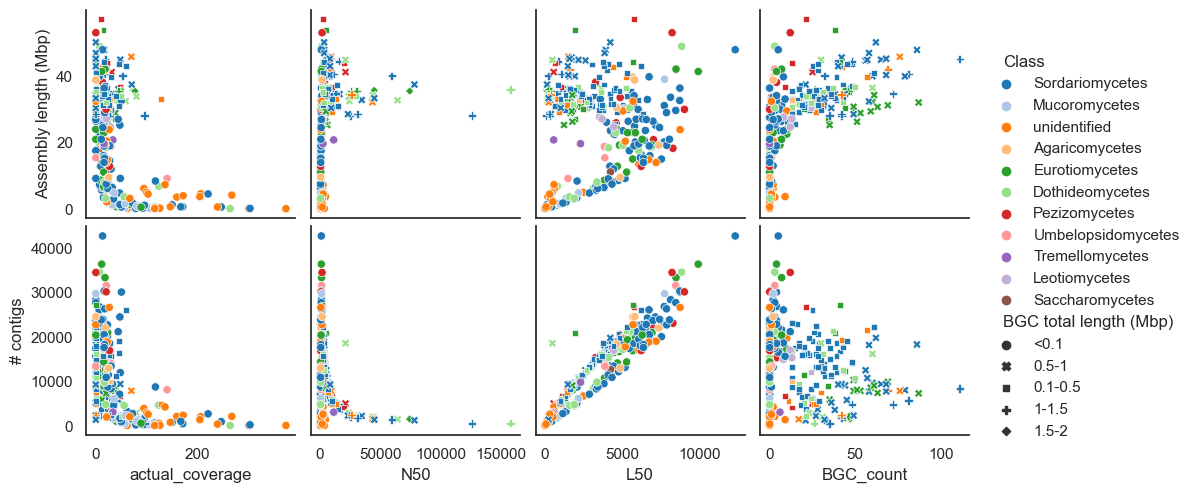

In [69]:
sns.set_style(style='white')

g = sns.PairGrid(data=df4, \
                 y_vars=["Assembly length (Mbp)", "# contigs"], \
                 x_vars=["actual_coverage", "N50", "L50", "BGC_count"],
                 hue="Class", palette="tab20")
g.map_diag(sns.histplot, color=".3", multiple="stack", element="step", alpha=0.8)
g.map_offdiag(sns.scatterplot, style=df4["BGC total length (Mbp)"])
g.add_legend(title="", adjust_subtitles=True)
g.tight_layout()
plt.savefig("ELF_assembly_length_v_metrics_Class.svg", format="svg")
plt.show()

## Fig. 4.7 - Principal Components Analysis of fungal Class

A Principal Components Analysis (PCA) is a statstical method to display relevant information from a large dataset on a single plot. Essentially, it is a way of reducing dimensionality by transforming a large set of variables into a smaller one that still contains most of the information in the large set. Performing a PCA can additionally show the strength of relationship between certain variables (principal components) by the proximity of their ordinals (lines).

In this analysis two methods are used to perform the PCA analysis, to ensure that the analysis was accurate.

    - PCA is first performed using Prince
    - PCA is repeated with scikit-learn to verify the results and to prepare seaborn-compatible plots

In [81]:
# prepare dataframe of the relevant data
df5 = df4.drop(columns=["Species", "BGC total length (Mbp)", "pooled_library"])
df5["Class"] = df5["Class"].dropna()
df5 = df5.fillna(0)
display(df5)

df6 = df[["actual_coverage", '# contigs', 'N50', 'L50', 'BGC_count', 'BUSCO - C', 'Total length', 'total_BGC_length', 'pooled_library']]
df6["complete_buscos"] = df6["BUSCO - C"].str.split("(").str[1].str.split("%").str[0]
df6 = df6.drop(columns=["BUSCO - C"])
df6 = df6.fillna(0)
display(df6)

,actual_coverage,# contigs,N50,L50,BGC_count,complete_buscos,Assembly length (Mbp),Class
0,12.621764,20079.0,1548.0,5392.0,7.0,49.62,26.325374,Sordariomycetes
1,100.296152,608.0,645.0,230.0,0.0,0.4,0.422249,Mucoromycetes
2,107.740790,365.0,628.0,137.0,0.0,0.2,0.251402,Mucoromycetes
3,268.158867,2093.0,3027.0,296.0,1.0,0,4.107569,unidentified
4,106.147437,244.0,666.0,94.0,0.0,0.2,0.169957,Mucoromycetes
...,...,...,...,...,...,...,...,...
375,0.000000,1341.0,45108.0,229.0,32.0,92.45,33.263602,Sordariomycetes
376,25.070219,12937.0,708.0,4862.0,0.0,1.5,9.472522,Agaricomycetes
377,10.723522,23801.0,908.0,8068.0,0.0,13.64,20.908769,Sordariomycetes
378,0.000000,24528.0,1997.0,5817.0,2.0,42.99,38.732199,Agaricomycetes


C:\Users\styleske\AppData\Local\Temp\ipykernel_12144\1068431406.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df6["complete_buscos"] = df6["BUSCO - C"].str.split("(").str[1].str.split("%").str[0]


,actual_coverage,# contigs,N50,L50,BGC_count,Total length,total_BGC_length,pooled_library,complete_buscos
0,12.621764,20079.0,1548.0,5392.0,7.0,26325374.0,47884.0,1,49.62
1,100.296152,608.0,645.0,230.0,0.0,422249.0,0.0,1,0.4
2,107.740790,365.0,628.0,137.0,0.0,251402.0,0.0,1,0.2
3,268.158867,2093.0,3027.0,296.0,1.0,4107569.0,6750.0,1,0
4,106.147437,244.0,666.0,94.0,0.0,169957.0,0.0,1,0.2
...,...,...,...,...,...,...,...,...,...
375,0.000000,1341.0,45108.0,229.0,32.0,33263602.0,885411.0,2,92.45
376,25.070219,12937.0,708.0,4862.0,0.0,9472522.0,0.0,2,1.5
377,10.723522,23801.0,908.0,8068.0,0.0,20908769.0,0.0,2,13.64
378,0.000000,24528.0,1997.0,5817.0,2.0,38732199.0,11958.0,2,42.99


Below is a PCA is performed with Prince with 4 principal components. The eigenvalue of each component is used to assess the importance of that principal component to the dataset.

In [86]:
pca = prince.PCA(
    n_components=3,
    n_iter=3,
    rescale_with_mean=True,
    rescale_with_std=True,
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=42
)
pca = pca.fit(df6)
pca.eigenvalues_summary

,eigenvalue,% of variance,% of variance (cumulative)
component,,,
0,3.677,40.86%,40.86%
1,2.725,30.28%,71.14%
2,0.977,10.85%,82.00%


A scree plot of this plot shows the eigenvalues in barplot form. Because the 3rd and 4th principal components (principal components 2 & 3) have similar eignevalues, we can say that the first 3 prinicipal components are sufficient to describe the dataset's variation.

In [87]:
pca.scree_plot()

alt.Chart(...)

Then we can transform all the data into coordinates and plot them.

In [88]:
pca.transform(df6).head()

component,0,1,2
0,-0.450686,1.217931,-1.312035
1,-1.773247,-2.623039,-1.143365
2,-1.795547,-2.723334,-1.109434
3,-2.131322,-3.791044,-0.348491
4,-1.788266,-2.730622,-1.116479


In [89]:
pca.column_coordinates_

component,0,1,2
variable,,,
actual_coverage,-0.317225,-0.705920,0.243543
# contigs,-0.138448,0.955788,0.006189
N50,0.575398,-0.322880,0.039725
L50,-0.316152,0.897377,-0.033030
BGC_count,0.891180,0.038376,0.067703
Total length,0.759539,0.567823,0.053748
total_BGC_length,0.929970,-0.178423,0.046592
pooled_library,-0.226923,0.177612,0.943098
complete_buscos,0.916066,0.129502,0.124813


In [90]:
pca.plot(
    df6,
    x_component=0,
    y_component=1,
    show_rows=True,
    show_columns=True
)

alt.LayerChart(...)

The following dataframe is prepared and PCA performed using `scikit-learn`, then the results are plotted. The Prince and scikit-learn PCA plots look identical, demonstrating these analyses are both accurate.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

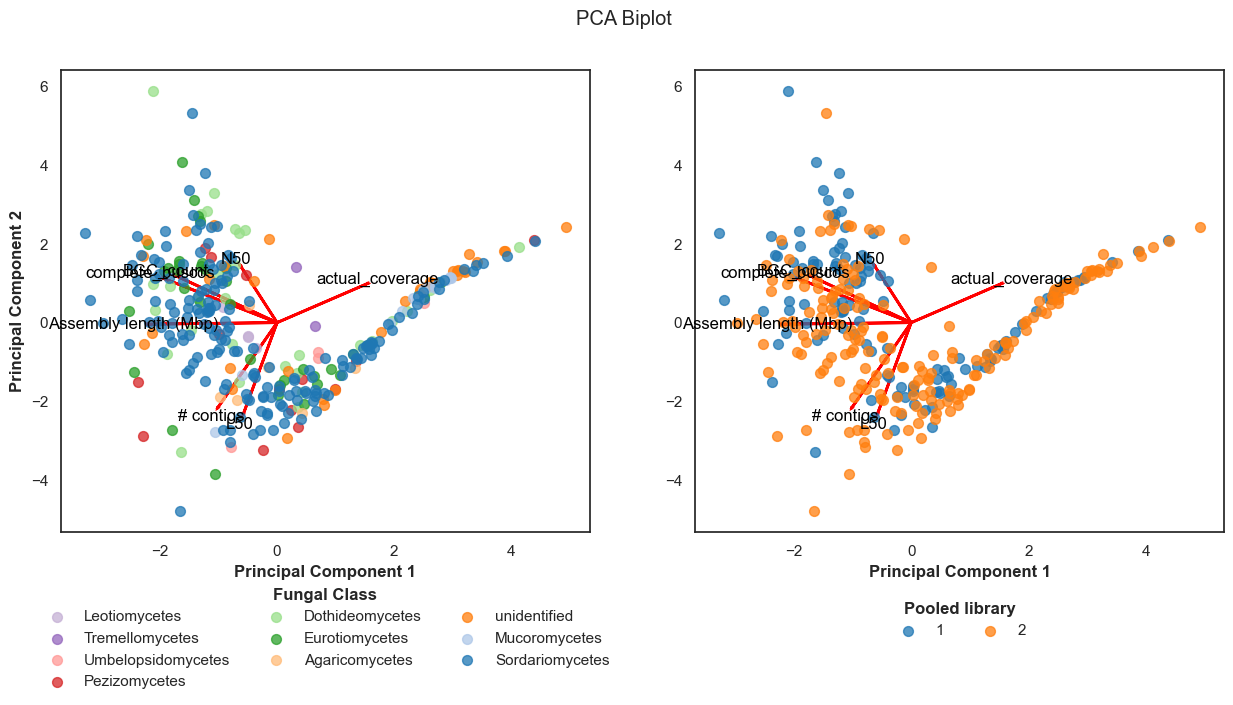

In [91]:
## prepare data
df7 = df4.drop(columns=["Species", "BGC total length (Mbp)", "pooled_library"])
df7["Class"] = df7["Class"].fillna("Unknown")
df7 = df7.fillna(0)
df8 = df4.drop(columns=["Species", "BGC total length (Mbp)", "Class"])
df8 = df8.fillna(0)
df8 = df8[["actual_coverage", '# contigs', 'N50', 'L50', 'BGC_count', 'complete_buscos', 'Assembly length (Mbp)', 'pooled_library']]

## Perform PCAs
# separate the features from the target variable and the class column
X1 = df7.iloc[:, :-1].values
y1 = df7.iloc[:, -1].values
# standardize the data
scaler = StandardScaler()
X1 = scaler.fit_transform(X1)
# perform PCA
pca1 = PCA()
principalComponents1 = pca1.fit_transform(X1)
# create a biplot
loading_scores1 = pd.DataFrame(pca1.components_.T, columns=[f'PC{i}' for i in range(1, pca1.n_components_+1)], index=df7.columns[:-1])

# separate the features from the target variable and the class column
X2 = df8.iloc[:, :-1].values
y2 = df8.iloc[:, -1].values
# standardize the data
X2 = scaler.fit_transform(X2)
# perform PCA
pca2 = PCA()
principalComponents2 = pca2.fit_transform(X2)
# create a biplot
loading_scores2 = pd.DataFrame(pca2.components_.T, columns=[f'PC{i}' for i in range(1, pca2.n_components_+1)], index=df8.columns[:-1])

## Plot each of the PCA biplots
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,6))

# assign colours for each marker in each dataset
# for fungal Class
classes = df7["Class"].unique()
tab20 = sns.color_palette("tab20", 20)
tab10 = sns.color_palette("tab10", 20)
n = len(classes) - 2
colors1 = {}
while n >= 0:
    colors1[classes[n]] = tab20[n]
    n-=1
# for datasets
colors2 = {"1":tab10[0], "2":tab10[1]}

# plot the principal components for fungal Class
for i, feature in enumerate(df7.columns[:-1]):
    ax1.arrow(0, 0, loading_scores1.loc[feature, 'PC1']*4, loading_scores1.loc[feature, 'PC2']*4, color='red', alpha=1, linewidth=2)
    ax1.text(loading_scores1.loc[feature, 'PC1']*4.4, loading_scores1.loc[feature, 'PC2']*4.4, feature, color='black', ha='center', va='center')
for class_name, color in colors1.items():
    indices = np.where(y1 == class_name)[0]
    ax1.scatter(principalComponents1[indices, 0], principalComponents1[indices, 1], s=50, alpha=0.75, c=color, label=class_name)
ax1.legend(title="Fungal Class", loc='lower center', bbox_to_anchor=(0.5, -0.37), frameon=False, ncol=3, title_fontproperties={'weight':"bold"})
ax1.set_xlabel('Principal Component 1', fontproperties={'weight':"bold"})
ax1.set_ylabel('Principal Component 2', fontproperties={'weight':"bold"})

# plot the principal components for dataset
for i, feature in enumerate(df8.columns[:-1]):
    ax2.arrow(0, 0, loading_scores2.loc[feature, 'PC1']*4, loading_scores2.loc[feature, 'PC2']*4, color='red', alpha=1, linewidth=2)
    ax2.text(loading_scores2.loc[feature, 'PC1']*4.4, loading_scores2.loc[feature, 'PC2']*4.4, feature, color='black', ha='center', va='center')
for class_name, color in colors2.items():
    indices = np.where(y2 == class_name)[0]
    ax2.scatter(principalComponents2[indices, 0], principalComponents2[indices, 1], s=50, alpha=0.75, c=color, label=class_name)
ax2.legend(title="Pooled library", loc='lower center', bbox_to_anchor=(0.5, -0.26), frameon=False, ncol=3, title_fontproperties={'weight':"bold"})
ax2.set_xlabel('Principal Component 1', fontproperties={'weight':"bold"})
fig.suptitle('PCA Biplot')
fig.savefig("PCA_biplot_dataset_fclass.svg", format="svg", bbox_inches='tight')
plt.show()
